In [1]:
import numpy as np
import matplotlib.pyplot as ppt
%matplotlib inline
import caffe
import adex
import adex.core
import adex.googlenet

CAFFE_ROOT = '/home/chrisbot/Projects/caffe'
IMAGE_PATH = '/media/sf_Masterarbeit/data/example_images/panda.jpg'
START_CLASS_NAME = 'n02510455'
TARGET_CLASS_NAME = 'n12267677'
BATCH_SIZE = 1

AE_GRAD_COEFF = 0.9
ITERATIONS = 100

net = adex.googlenet.load_model(CAFFE_ROOT + '/models/bvlc_googlenet/deploy.prototxt',
                                CAFFE_ROOT + '/models/bvlc_googlenet/bvlc_googlenet.caffemodel',
                                BATCH_SIZE)
labels = adex.googlenet.load_labels(CAFFE_ROOT)
transformer = adex.googlenet.build_transformer(net)

In [2]:
def predict(net, image):
    net.blobs['data'].data[...] = image
    probabilities = net.forward()['prob'][0]
    predictions = probabilities.argsort()[::-1]
    
    return predictions, probabilities

def compute_gradient(net, image, desired_label):
    #_, _ = predict(net, image) # FIXME this SHOULD not be necessary since turn_into() class predict.
    probs = np.zeros_like(net.blobs['prob'].data)
    probs[0][desired_label] = 1
    
    gradient = net.backward(prob=probs, diffs=['data'])
    return gradient['data'].copy()

def turn_into(net, image, desired_label, c, iterations):
    ae = image.copy()
    
    pred_history, prob_history = predict(net, ae)
    for _ in range(iterations):
        gradient = compute_gradient(net, ae, desired_label)
        ae = ae + (c / iterations) * np.sign(gradient)
        
        preds, probs = predict(net, ae)
        pred_history = np.vstack([pred_history, preds])
        prob_history = np.vstack([prob_history, probs])
    
    return ae, pred_history, prob_history

In [3]:
image = caffe.io.load_image(IMAGE_PATH)
image = transformer.preprocess('data', image)
image = np.expand_dims(image, 0)

target_label = adex.googlenet.get_label_from_class_name(labels, TARGET_CLASS_NAME)
target_label = np.array([target_label]) # Caffe-friendly format for labels

ae, pred_history, prob_history = turn_into(net, image, target_label, AE_GRAD_COEFF, ITERATIONS)

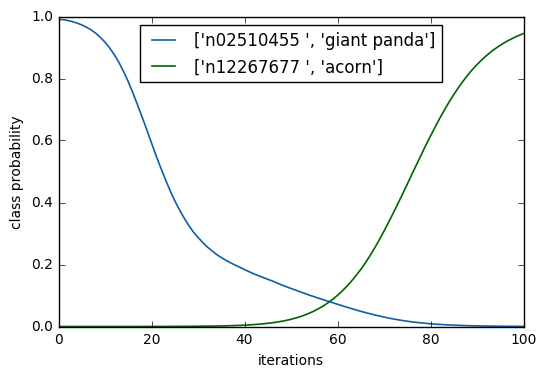

In [4]:
def plot_probabilities(prob_history, print_labels, colors):
    for l, c in zip(print_labels, colors):
        probs = prob_history[:, l]
        ppt.plot(probs, label=labels[l][:2], color=c, linewidth=1.2)
        ppt.legend(loc='upper center')
    
    ppt.xlabel('iterations')
    ppt.ylabel('class probability')

colors = ('#115EA6', 'darkgreen')
start_label = adex.googlenet.get_label_from_class_name(labels, START_CLASS_NAME)
plot_probabilities(prob_history, [start_label, target_label[0]], colors)

In [5]:
common_prob = np.sum(prob_history[:, [start_label, target_label[0]]], axis=1)
print('Lowest probability for source and target class combined after iteration {0}'.format(np.argmin(common_prob)))

Lowest probability for source and target class combined after iteration 53
